<h2> We try a simple logit model for telephone data </h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit

In [2]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_telephone_LM(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']

    sum_total = np.exp(data['U_1']) * data['avail1'] + np.exp(data['U_2']) * data['avail2'] + \
                np.exp(data['U_3']) * data['avail3'] + np.exp(data['U_4']) * data['avail4'] + \
                np.exp(data['U_5']) * data['avail5']
    
    # Full probabilities
    data['P_1'] = np.exp(data['U_1']) * data['avail1'] / sum_total
    data['P_2'] = np.exp(data['U_2']) * data['avail2'] / sum_total
    data['P_3'] = np.exp(data['U_3']) * data['avail3'] / sum_total
    data['P_4'] = np.exp(data['U_4']) * data['avail4'] / sum_total
    data['P_5'] = np.exp(data['U_5']) * data['avail5'] / sum_total
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [3]:
# Load data
data = pd.read_csv('./data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0])

beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]


In [4]:
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_LM)

Optimization Results:
   Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0      ASC_1 -0.721243              0.153463    -4.699777  3.514203e-06
1      ASC_3  1.201266              0.154843     7.757947  6.372680e-14
2      ASC_4  0.999199              0.702369     1.422612  1.555754e-01
3      ASC_5  1.736400              0.275862     6.294454  7.631404e-10
4  BETA_COST -2.026204              0.213538    -9.488723  0.000000e+00
AIC: 965.1137706159915
BIC: 985.4789932864935


In [5]:
data

,choice,area,users,inc,age0,age1,age2,age3,age4,age5,...,U_2,U_3,U_4,U_5,P_1,P_2,P_3,P_4,P_5,P
0,2,1,2,4,0,0,0,1,1,0,...,-3.554780,-3.956500,-26.993845,-4.641269,0.192843,0.402258,0.269178,0.0,0.135721,0.402258
1,3,1,1,2,0,0,0,0,0,0,...,-3.554780,-3.880397,-26.993845,-4.641269,0.392023,0.295209,0.213165,0.0,0.099603,0.213165
2,1,2,2,4,0,0,0,2,0,0,...,-3.554780,-3.742135,-26.993845,-5.035488,0.234203,0.372356,0.308739,0.0,0.084702,0.234203
3,3,2,2,3,1,0,0,0,2,0,...,-3.554780,-3.555367,-26.993845,-5.035488,0.245235,0.338932,0.338733,0.0,0.077099,0.338733
4,3,2,6,3,1,3,2,1,0,2,...,-3.957232,-4.193209,-26.993845,-5.035488,0.133748,0.406694,0.321206,0.0,0.138353,0.321206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,2,5,2,3,2,0,0,1,1,0,...,-4.401881,-3.130172,-26.993845,-26.256644,0.071780,0.203248,0.724973,0.0,0.000000,0.203248
430,3,5,2,3,0,0,0,1,1,0,...,-3.960104,-3.130172,-26.993845,-26.256644,0.090838,0.276076,0.633087,0.0,0.000000,0.633087
431,2,5,3,4,0,0,0,1,0,1,...,-3.554780,-3.130172,-26.993845,-26.256644,0.109940,0.351943,0.538118,0.0,0.000000,0.351943
432,2,5,1,2,0,0,0,0,0,0,...,-3.554780,-3.130172,-26.993845,-26.256644,0.153008,0.334913,0.512079,0.0,0.000000,0.334913


---
---
---
---
---

<h2> Applying DIB algorithm </h2>

In [6]:
# Computation of p(x)
data_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]

# Function to compare rows with a reference row
def count_same_rows(df):
    row_counts = {}

    for index, row in df.iterrows():
        # Convert the row to a tuple to make it hashable
        row_tuple = tuple(row)
        
        # Count the occurrences of the row in the dataframe
        if row_tuple in row_counts:
            row_counts[row_tuple] += 1
        else:
            row_counts[row_tuple] = 1
            
    return row_counts

# Count occurrences of each row
row_counts = count_same_rows(data_logcost)

# Add a new column with probabilities
total_rows = len(data_logcost)
data_logcost['probability'] = data_logcost.apply(lambda row: row_counts[tuple(row)] / total_rows, axis=1)
data_logcost.head()


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_69341/3559485977.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_logcost['probability'] = data_logcost.apply(lambda row: row_counts[tuple(row)] / total_rows, axis=1)


,logcost1,logcost2,logcost3,logcost4,logcost5,probability
0,1.761300,1.754404,2.545531,13.815511,3.147595,0.002304
1,1.258461,1.754404,2.507972,13.815511,3.147595,0.002304
2,1.627278,1.754404,2.439735,13.815511,3.342155,0.002304
3,1.558145,1.754404,2.347558,13.815511,3.342155,0.002304
4,2.145931,1.953028,2.662355,13.815511,3.342155,0.002304


In [7]:
# Computation of p(x,y)
p_x = data_logcost['probability'].values
# p_x is the unfirom distribution
#p_x = np.ones(len(data_logcost)) / len(data_logcost)
# p_x is random distribution
#p_x = np.random.rand(len(data_logcost))
#p_x /= p_x.sum()

p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [8]:
from functions_geom_DIB import geom_DIB_on_alternatives

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000


Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 5000
Iteration: 40 out of 5000
Iteration: 41 out of 5000
Iteration: 42 out of 5000
Iteration: 43 out of 5000
Iteration: 44 out of 5000
Iteration: 45 out of 5000
Iteration: 46 out of 5000
Iteration: 47 out of 5000
Iteration: 4

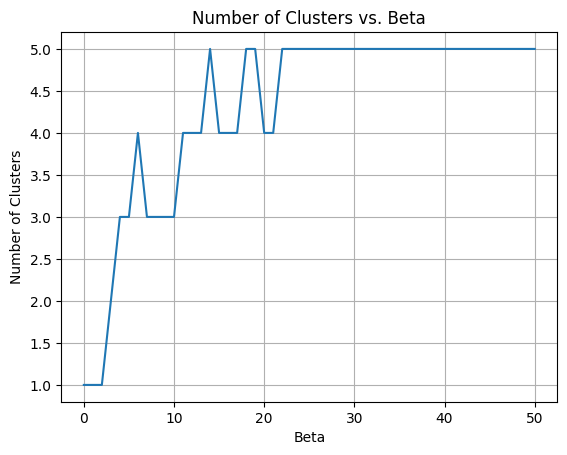

In [9]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

<h2> Take beta = 5 and try different distributions for p(x) </h2>

In [10]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=5, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

In [11]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
num_clusters

3

In [12]:
# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
data['cluster'].value_counts()

cluster
3    404
4     21
0      9
Name: count, dtype: int64

In [13]:
# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
cluster_counts

choice,1,2,3,4,5
cluster,,,,,
0,2,1,3,3,0
3,71,121,174,0,38
4,0,1,1,0,19


In [14]:
data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)

# display the alternative with the second max value of probability
data['second_max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].apply(lambda x: x.nlargest(2).index[-1][-1], axis=1).astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
cluster_counts2

max_proba,1,2,3,4,5
cluster,,,,,
0,0,0,7,2,0
3,49,110,229,0,16
4,0,0,0,0,21


In [15]:
pd.set_option('display.max_rows', None)
subdata = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'cluster', 'choice', 'max_proba', 'second_max_proba']]
#subdata[(subdata['P_5'] == 0) & (subdata['P_4'] == 0)]

In [16]:
data_joint = pd.DataFrame(p_xy, columns=['P_x1', 'P_x2', 'P_x3', 'P_x4', 'P_x5'])
data_joint['cluster'] = data['cluster']
data_joint['max_proba'] = data['max_proba']
data_joint['second_max_proba'] = data['second_max_proba']
data_joint[(data_joint['P_x4'] != 1e-20) & (data_joint['P_x5'] != 1e-20)]
#data_joint[(data_joint['P_x4'] == 1e-20) & (data_joint['max_proba'] == 5)]

,P_x1,P_x2,P_x3,P_x4,P_x5,cluster,max_proba,second_max_proba
67,0.000115,0.000182,0.000432,0.001005,0.000152,0,4,3
68,0.000017,0.000034,0.000108,0.000159,0.001569,4,5,4
69,0.000001,0.000002,0.000008,0.000007,0.001869,4,5,3
70,0.000179,0.000294,0.000700,0.000461,0.000252,0,3,4
71,0.000011,0.000021,0.000068,0.000060,0.001727,4,5,3
91,0.000038,0.000083,0.000433,0.000378,0.000955,4,5,3
92,0.000328,0.000337,0.000645,0.000483,0.000093,0,3,4
97,0.000088,0.000233,0.000836,0.000615,0.000115,0,3,4
153,0.000410,0.000401,0.000647,0.000370,0.000059,0,3,1
154,0.000048,0.000115,0.000720,0.000851,0.000152,0,4,3


For beta = 5 and p(x) the empirical distribution, the clusters are determined in this way : 

max_proba	1	2	3	4	5
cluster					
0	        0	0	7	2	0
3	        49	110	229	0	16
4	        0	0	0	0	21

- cluster 0: all alternatives available, max_proba different from 5

- cluster 3: 
    1. alternatives 4 and 5 are missing 
    2. alternative 4 is missing, max_proba different from 5 OR max_proba = 5 and P_x5 < 0.00193

- cluster 4:
    1. all alternatives available, max_proba = 5
    2. alternative 4 is missing, max_proba = 5 and P_x5 >= 0.00193

For beta = 5 and p(x) the uniform distribution, the clusters are determined in the same way.  



For beta = 5 and p(x) random, the clusters are almost the same. 

It seems that the choice of p(x) has not a big impact on how the algorithm determines clusters.

<h2> Take beta = 1e10 and compare the results with what we find with NLM and CNLM </h2>

In [17]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=1e10, max_iter=5000, threshold=1e-30)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000


In [18]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
num_clusters

5

In [19]:
# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
data['cluster'].value_counts()

cluster
0    134
1    127
3    106
4     57
2     10
Name: count, dtype: int64

In [20]:
# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
cluster_counts

choice,1,2,3,4,5
cluster,,,,,
0,22,59,53,0,0
1,12,42,54,0,19
2,2,1,3,3,1
3,35,18,50,0,3
4,2,3,18,0,34


In [21]:
data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)

# display the alternative with the second max value of probability
data['second_max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].apply(lambda x: x.nlargest(2).index[-1][-1], axis=1).astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
cluster_counts2

max_proba,1,2,3,4,5
cluster,,,,,
0,0,0,134,0,0
1,0,78,49,0,0
2,0,0,7,2,1
3,49,32,25,0,0
4,0,0,21,0,36


<h2> Here again, the algorithm seems to indicate that alternative 3 is between two nests and these nests are 1,2 against 4,5 </h2>